In [10]:
!pip install optuna

In [11]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [12]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

In [13]:
df = pd.read_csv('btc_15m.csv')
df = df.dropna()
df.head()

datetime      open      high       low     close      volume
0  2018-01-01 05:30:00  13715.65  13715.65  13400.01  13556.15  123.616013
1  2018-01-01 05:45:00  13533.75  13550.87  13402.00  13521.12   98.136430
2  2018-01-01 06:00:00  13500.00  13545.37  13450.00  13470.41   79.904037
3  2018-01-01 06:15:00  13494.65  13690.87  13450.00  13529.01  141.699719
4  2018-01-01 06:30:00  13528.99  13571.74  13402.28  13445.63   72.537533

In [14]:
d1 = pd.to_datetime(df.iloc[0].datetime)
d2 = pd.to_datetime(df.iloc[-1].datetime)

start_date=datetime.datetime(d1.year, d1.month, d1.day)
end_date=datetime.datetime(d2.year, d2.month, d2.day)

df['datetime'] = pd.to_datetime(df['datetime'])
df = df[df['datetime'].dt.strftime('%d') < '29']

df.index=pd.to_datetime(df["datetime"])
df=df.drop("datetime",axis=1)


In [15]:
df.head(115)

open      high       low     close      volume
datetime                                                               
2018-01-01 05:30:00  13715.65  13715.65  13400.01  13556.15  123.616013
2018-01-01 05:45:00  13533.75  13550.87  13402.00  13521.12   98.136430
2018-01-01 06:00:00  13500.00  13545.37  13450.00  13470.41   79.904037
2018-01-01 06:15:00  13494.65  13690.87  13450.00  13529.01  141.699719
2018-01-01 06:30:00  13528.99  13571.74  13402.28  13445.63   72.537533
...                       ...       ...       ...       ...         ...
2018-01-02 09:00:00  13400.00  13449.76  13326.86  13421.25  144.716881
2018-01-02 09:15:00  13402.73  13447.89  13306.00  13353.78  137.256941
2018-01-02 09:30:00  13353.78  13467.78  13306.00  13435.74  190.165912
2018-01-02 09:45:00  13435.74  13480.84  13012.00  13047.00  265.916575
2018-01-02 10:00:00  13047.00  13130.98  12890.02  13071.00  388.201980

[115 rows x 5 columns]

In [16]:
dfm=df.resample("D").mean()

dfm=dfm[:-1]
dfm = dfm[dfm.index.strftime('%d') < '29']
dfm.dropna()

dfm.head(40)

open          high           low         close  \
datetime                                                             
2018-01-01  13369.790405  13443.175270  13278.252297  13364.116351   
2018-01-02  13477.295625  13547.641042  13411.748438  13488.488021   
2018-01-03  14850.705521  14946.316354  14751.329479  14853.446979   
2018-01-04  14676.923596  14743.072472  14602.602809  14678.245618   
2018-01-05  15396.607708  15490.136875  15323.896354  15423.427708   
2018-01-06  16630.387917  16710.313229  16532.514896  16632.465104   
2018-01-07  16656.078438  16718.370000  16573.643437  16643.730417   
2018-01-08  15506.652188  15616.394375  15365.628958  15498.095417   
2018-01-09  14886.528542  14986.154792  14771.406667  14886.125104   
2018-01-10  14159.031250  14260.080208  14048.793333  14154.914896   
2018-01-11  13878.370625  14005.865937  13737.530312  13869.853542   
2018-01-12  13530.912604  13641.200417  13423.109062  13528.533646   
2018-01-13  14041.874687  14107.951250  13977.801667  14052.221146   
2018-01-14  13708.243854  13777.671458  13611.180625  13698.113646   
2018-01-15  13589.515104  13657.599375  13514.968646  13594.652917   
2018-01-16  12559.777604  12688.082083  12387.924375  12529.999583   
2018-01-17  10343.014479  10548.703542  10131.970833  10328.999687   
2018-01-18  11037.236250  11193.843958  10899.152500  11054.572187   
2018-01-19  11262.878229  11360.410417  11157.153125  11263.257812   
2018-01-20  12076.783438  12160.414896  12010.005625  12095.122708   
2018-01-21  12148.207396  12225.930104  12046.384583  12131.281042   
2018-01-22  11268.960729  11356.275208  11168.514479  11262.014583   
2018-01-23  10535.919271  10623.629792  10435.017292  10541.223958   
2018-01-24  10951.827604  11027.164583  10879.825208  10950.822917   
2018-01-25  11304.137917  11356.340417  11250.124062  11304.175625   
2018-01-26  11082.916250  11141.919062  11013.388437  11082.101667   
2018-01-27  11126.374896  11186.339896  11077.756042  11129.848646   
2018-01-28  11742.684479  11788.608229  11697.718437  11745.880938   
2018-02-01   9872.125937   9919.868125   9814.845417   9861.687396   
2018-02-02   8831.382604   8922.601146   8739.259687   8826.597917   
2018-02-03   8828.780625   8897.755729   8765.629479   8834.781875   
2018-02-04   8985.177083   9036.835417   8922.303646   8976.337083   
2018-02-05   7924.825104   7990.853542   7846.888021   7911.090833   
2018-02-06   6719.243750   6839.879375   6615.772812   6718.150833   
2018-02-07   7737.578958   7828.004063   7669.416979   7750.791875   
2018-02-08   7980.574167   8052.640417   7909.101250   7959.246250   
2018-02-09   8350.244706   8419.462353   8315.542353   8374.728824   
2018-02-10   8660.602105   8714.387053   8609.199158   8657.466000   
2018-02-11   8194.061789   8246.271158   8139.425684   8191.340632   
2018-02-12   8490.338646   8534.900104   8449.664271   8495.530000   

                 volume  
datetime                 
2018-01-01    92.852895  
2018-01-02   162.149562  
2018-01-03   209.801084  
2018-01-04   209.459416  
2018-01-05   231.567799  
2018-01-06   211.495181  
2018-01-07   153.525174  
2018-01-08   259.903748  
2018-01-09   154.498368  
2018-01-10   190.470802  
2018-01-11   309.556491  
2018-01-12   209.182970  
2018-01-13   131.427651  
2018-01-14   171.426864  
2018-01-15   150.090206  
2018-01-16   458.103996  
2018-01-17   790.109399  
2018-01-18   593.849819  
2018-01-19   408.682371  
2018-01-20   304.027383  
2018-01-21   402.598489  
2018-01-22   418.820644  
2018-01-23   430.960692  
2018-01-24   310.330135  
2018-01-25   228.646810  
2018-01-26   341.294529  
2018-01-27   195.984044  
2018-01-28   186.095102  
2018-02-01   261.200598  
2018-02-02   562.133033  
2018-02-03   318.027756  
2018-02-04   266.153869  
2018-02-05   518.031830  
2018-02-06  1101.013049  
2018-02-07   705.288437  
2018-02-08   571.619231  
2018-02-09   404.855230  
2018-02-10   483.252482  
2018-02-11   508.282199  
2018-02-12   

In [17]:
start_year=start_date.year
start_month=start_date.month
end_year=end_date.year
end_month=end_date.month

first_days=[]
# First year
for month in range(start_month,13):
    for day in range(1, 29):
        first_days.append(min(df[str(start_year)+"-"+str(month)+"-"+str(day)].index))
# Other years
for year in range(start_year+1,end_year):
    for month in range(1,13):
        for day in range(1,29):
            first_days.append(min(df[str(start_year)+"-"+str(month)+"-"+str(day)].index))
# Last year
for month in range(1,end_month+1):
    for day in range(1,29):
        first_days.append(min(df[str(start_year)+"-"+str(month)+"-"+str(day)].index))

<ipython-input-17-021d4caf3770>:10: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  first_days.append(min(df[str(start_year)+"-"+str(month)+"-"+str(day)].index))
<ipython-input-17-021d4caf3770>:15: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  first_days.append(min(df[str(start_year)+"-"+str(month)+"-"+str(day)].index))
<ipython-input-17-021d4caf3770>:19: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  first_days.append(min(df[str(start_year)+"-"+str(month)+"-"+str(day)].index))


In [18]:
print(first_days)

[Timestamp('2018-01-01 05:30:00'), Timestamp('2018-01-02 00:00:00'), Timestamp('2018-01-03 00:00:00'), Timestamp('2018-01-04 00:00:00'), Timestamp('2018-01-05 00:00:00'), Timestamp('2018-01-06 00:00:00'), Timestamp('2018-01-07 00:00:00'), Timestamp('2018-01-08 00:00:00'), Timestamp('2018-01-09 00:00:00'), Timestamp('2018-01-10 00:00:00'), Timestamp('2018-01-11 00:00:00'), Timestamp('2018-01-12 00:00:00'), Timestamp('2018-01-13 00:00:00'), Timestamp('2018-01-14 00:00:00'), Timestamp('2018-01-15 00:00:00'), Timestamp('2018-01-16 00:00:00'), Timestamp('2018-01-17 00:00:00'), Timestamp('2018-01-18 00:00:00'), Timestamp('2018-01-19 00:00:00'), Timestamp('2018-01-20 00:00:00'), Timestamp('2018-01-21 00:00:00'), Timestamp('2018-01-22 00:00:00'), Timestamp('2018-01-23 00:00:00'), Timestamp('2018-01-24 00:00:00'), Timestamp('2018-01-25 00:00:00'), Timestamp('2018-01-26 00:00:00'), Timestamp('2018-01-27 00:00:00'), Timestamp('2018-01-28 00:00:00'), Timestamp('2018-02-01 00:00:00'), Timestamp('20

In [19]:
dfm["fd_cm"]=first_days[:-1]
dfm["fd_nm"]=first_days[1:]
dfm["fd_cm_open"]=np.array(df.loc[first_days[:-1],"open"])
dfm["fd_nm_open"]=np.array(df.loc[first_days[1:],"open"])
dfm["rapp"]=dfm["fd_nm_open"].divide(dfm["fd_cm_open"])

In [20]:
dfm.head()

open          high           low         close  \
datetime                                                             
2018-01-01  13369.790405  13443.175270  13278.252297  13364.116351   
2018-01-02  13477.295625  13547.641042  13411.748438  13488.488021   
2018-01-03  14850.705521  14946.316354  14751.329479  14853.446979   
2018-01-04  14676.923596  14743.072472  14602.602809  14678.245618   
2018-01-05  15396.607708  15490.136875  15323.896354  15423.427708   

                volume               fd_cm      fd_nm  fd_cm_open  fd_nm_open  \
datetime                                                                        
2018-01-01   92.852895 2018-01-01 05:30:00 2018-01-02    13715.65    13180.18   
2018-01-02  162.149562 2018-01-02 00:00:00 2018-01-03    13180.18    14370.02   
2018-01-03  209.801084 2018-01-03 00:00:00 2018-01-04    14370.02    14768.55   
2018-01-04  209.459416 2018-01-04 00:00:00 2018-01-05    14768.55    14744.99   
2018-01-05  231.567799 2018-01-05 00:00:00 2018-01-06    14744.99    16897.00   

                rapp  
datetime              
2018-01-01  0.960959  
2018-01-02  1.090275  
2018-01-03  1.027733  
2018-01-04  0.998405  
2018-01-05  1.145949

In [21]:
dfm["mv_avg_12"]= dfm["open"].rolling(window=12).mean().shift(1)
dfm["mv_avg_24"]= dfm["open"].rolling(window=24).mean().shift(1)

In [22]:
dfm=dfm.iloc[24:,:]
print(dfm.index)

DatetimeIndex(['2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28',
               '2018-02-01', '2018-02-02', '2018-02-03', '2018-02-04',
               '2018-02-05', '2018-02-06',
               ...
               '2022-01-18', '2022-01-19', '2022-01-20', '2022-01-21',
               '2022-01-22', '2022-01-23', '2022-01-24', '2022-01-25',
               '2022-01-26', '2022-01-27'],
              dtype='datetime64[ns]', name='datetime', length=1347, freq=None)


In [23]:
dfm.shape

(1347, 12)

In [24]:
mtest=int(0.2*dfm.shape[0])
train=dfm.iloc[:-mtest,:]
test=dfm.iloc[-mtest:,:]

In [25]:
print(test.shape)
print(train.shape)

(269, 12)
(1078, 12)


In [26]:
def create_window(data, window_size = 1):
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], axis = 1)

    data.dropna(axis=0, inplace=True)
    return(data)

In [27]:
dfm

open          high           low         close  \
datetime                                                             
2018-01-25  11304.137917  11356.340417  11250.124062  11304.175625   
2018-01-26  11082.916250  11141.919062  11013.388437  11082.101667   
2018-01-27  11126.374896  11186.339896  11077.756042  11129.848646   
2018-01-28  11742.684479  11788.608229  11697.718437  11745.880938   
2018-02-01   9872.125937   9919.868125   9814.845417   9861.687396   
...                  ...           ...           ...           ...   
2022-01-23  35318.540104  35446.416354  35204.447500  35325.271354   
2022-01-24  34836.530104  35015.516250  34678.433750  34843.555208   
2022-01-25  36381.467292  36534.339271  36257.857500  36398.623333   
2022-01-26  37438.784688  37556.635625  37330.869583  37442.629375   
2022-01-27  36547.005000  36668.008854  36396.768021  36528.640625   

                volume      fd_cm      fd_nm  fd_cm_open  fd_nm_open  \
datetime                                                               
2018-01-25  228.646810 2018-01-25 2018-01-26    11171.00    11199.97   
2018-01-26  341.294529 2018-01-26 2018-01-27    11199.97    11111.25   
2018-01-27  195.984044 2018-01-27 2018-01-28    11111.25    11487.99   
2018-01-28  186.095102 2018-01-28 2018-02-01    11487.99    10094.54   
2018-02-01  261.200598 2018-02-01 2018-02-02    10094.54     9145.00   
...                ...        ...        ...         ...         ...   
2022-01-23  449.779878 2018-01-23 2018-01-24    10619.81    11185.00   
2022-01-24  899.255469 2018-01-24 2018-01-25    11185.00    11171.00   
2022-01-25  611.913212 2018-01-25 2018-01-26    11171.00    11199.97   
2022-01-26  533.851376 2018-01-26 2018-01-27    11199.97    11111.25   
2022-01-27  697.382836 2018-01-27 2018-01-28    11111.25    11487.99   

                rapp     mv_avg_12     mv_avg_24  
datetime                                          
2018-01-25  1.002593  11960.353220  13355.980128  
2018-01-26  0.992079  11732.208490  13269.911274  
2018-01-27  1.033906  11513.431189  13170.145467  
2018-01-28  0.878704  11308.169505  13014.965024  
2018-02-01  0.905935  11240.078411  12892.705061  
...              ...           ...           ...  
2022-01-23  1.053220  41835.210729  43646.228676  
2022-01-24  0.998748  41285.108759  42997.181146  
2022-01-25  1.002593  40609.830009  42378.268242  
2022-01-26  0.992079  40002.255573  41942.428203  
2022-01-27  1.033906  39569.384036  41530.924740  

[1347 rows x 12 columns]

In [28]:
dfm.columns

Index(['open', 'high', 'low', 'close', 'volume', 'fd_cm', 'fd_nm',
       'fd_cm_open', 'fd_nm_open', 'rapp', 'mv_avg_12', 'mv_avg_24'],
      dtype='object')

In [29]:
scaler=MinMaxScaler(feature_range=(0,1))
dg=pd.DataFrame(scaler.fit_transform(dfm[["high","low","open","close","volume","fd_cm_open","fd_nm_open","mv_avg_12","mv_avg_24"]].values))
dg0=dg[[0,1,2,3,4,5,6,7]]


window=4
dfw=create_window(dg0,window)

X_dfw=np.reshape(dfw.values,(dfw.shape[0],window+1,8))
print(X_dfw.shape)
print(dfw.iloc[:4,:])
print(X_dfw[0,:,:])

y_dfw=np.array(dg[8][window:])

(1343, 5, 8)
          0         1         2         3         4         5         6  \
0  0.126604  0.125727  0.126168  0.126153  0.040549  0.582409  0.584522   
1  0.123266  0.122026  0.122717  0.122689  0.066925  0.584522  0.578051   
2  0.123958  0.123032  0.123395  0.123434  0.032901  0.578051  0.605527   
3  0.133333  0.132725  0.133008  0.133041  0.030585  0.605527  0.503904   

          7         0         1  ...         6         7         0         1  \
0  0.141349  0.123266  0.122026  ...  0.503904  0.130603  0.104245  0.103288   
1  0.137590  0.123958  0.123032  ...  0.434655  0.129481  0.088722  0.086473   
2  0.133985  0.133333  0.132725  ...  0.398554  0.128834  0.088335  0.086885   
3  0.130603  0.104245  0.103288  ...  0.438371  0.125805  0.090500  0.089334   

          2         3         4         5         6         7  
0  0.103830  0.103655  0.048171  0.503904  0.434655  0.129481  
1  0.087596  0.087512  0.118635  0.434655  0.398554  0.128834  
2  0.087556  0.087

In [30]:
X_trainw=X_dfw[:-mtest-1,:,:]
X_testw=X_dfw[-mtest-1:,:,:]
y_trainw=y_dfw[:-mtest-1]
y_testw=y_dfw[-mtest-1:]

print(X_trainw.shape)
print(X_testw.shape)

(1073, 5, 8)
(270, 5, 8)


In [31]:
window = window + 1
features = 8

def objective(trial):
    lstm_units_1 = trial.suggest_int('lstm_units_1', 50, 500)
    lstm_units_2 = trial.suggest_int('lstm_units_2', 50, 500)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.8)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    model = Sequential()
    model.add(LSTM(lstm_units_1, input_shape=(window, features), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units_2, input_shape=(window, features), return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(100, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='relu'))

    model.compile(loss='mse', optimizer='adam', run_eagerly=True)

    history = model.fit(X_trainw, y_trainw, epochs=10, batch_size=50, validation_data=(X_testw, y_testw), verbose=0)

    return history.history['val_loss'][-1]

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2024-01-12 22:45:28,777] A new study created in memory with name: no-name-86ccc296-de44-4407-b09f-e876a0c21275
<ipython-input-31-81042463d645>:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.8)
<ipython-input-31-81042463d645>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-01-12 22:46:51,939] Trial 0 finished with value: 0.00696812616661191 and parameters: {'lstm_units_1': 336, 'lstm_units_2': 80, 'dropout_rate': 0.6166215937176843, 'learning_rate': 0.00018196289931781152}. Best is trial 0 with value: 0.00696812616661191.
[I 2024-01-12 22:48:14,67

Best trial:
  Value:  0.0031927903182804585
  Params: 
    lstm_units_1: 364
    lstm_units_2: 260
    dropout_rate: 0.28779834763909107
    learning_rate: 0.0018139912112445874


In [32]:
arr = []
for key, value in trial.params.items():
    arr.append(value)

In [33]:
def model_lstm(window,features):

    model=Sequential()
    model.add(LSTM(arr[0], input_shape = (window,features), return_sequences=True))
    model.add(Dropout(arr[2]))
    model.add(LSTM(arr[1], input_shape=(window,features), return_sequences=False))
    model.add(Dropout(arr[2]))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))

    return model

Epoch 1/10
22/22 [==============================] - 5s 217ms/step - loss: 0.0153 - val_loss: 0.1765
Epoch 2/10
22/22 [==============================] - 5s 251ms/step - loss: 0.0049 - val_loss: 0.0075
Epoch 3/10
22/22 [==============================] - 5s 213ms/step - loss: 0.0012 - val_loss: 0.0057
Epoch 4/10
22/22 [==============================] - 5s 211ms/step - loss: 5.9853e-04 - val_loss: 0.0046
Epoch 5/10
22/22 [==============================] - 5s 247ms/step - loss: 5.8508e-04 - val_loss: 0.0068
Epoch 6/10
22/22 [==============================] - 4s 201ms/step - loss: 5.6855e-04 - val_loss: 0.0051
Epoch 7/10
22/22 [==============================] - 5s 212ms/step - loss: 5.3559e-04 - val_loss: 0.0036
Epoch 8/10
22/22 [==============================] - 5s 237ms/step - loss: 5.2302e-04 - val_loss: 0.0030
Epoch 9/10
22/22 [==============================] - 5s 213ms/step - loss: 6.7522e-04 - val_loss: 0.0040
Epoch 10/10
22/22 [==============================] - 5s 237ms/step - loss: 5

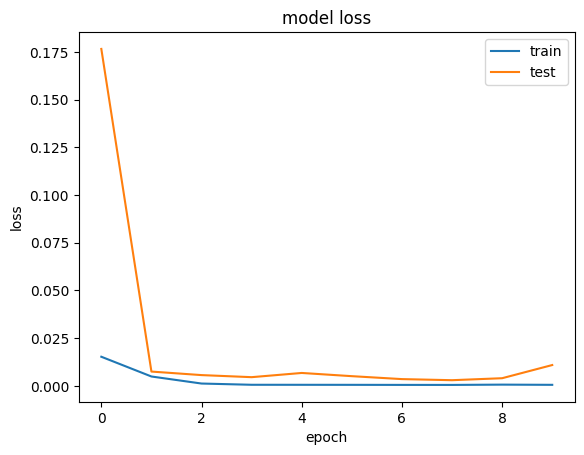

In [34]:
model=model_lstm(window,8)
model.compile(loss='mse',optimizer=Adam(learning_rate=arr[3]),run_eagerly=True)

history=model.fit(X_trainw,y_trainw,epochs=10, batch_size=50, validation_data=(X_testw, y_testw), verbose=1, callbacks=[])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [35]:
y_pr=model.predict(X_trainw)

34/34 [==============================] - 2s 60ms/step


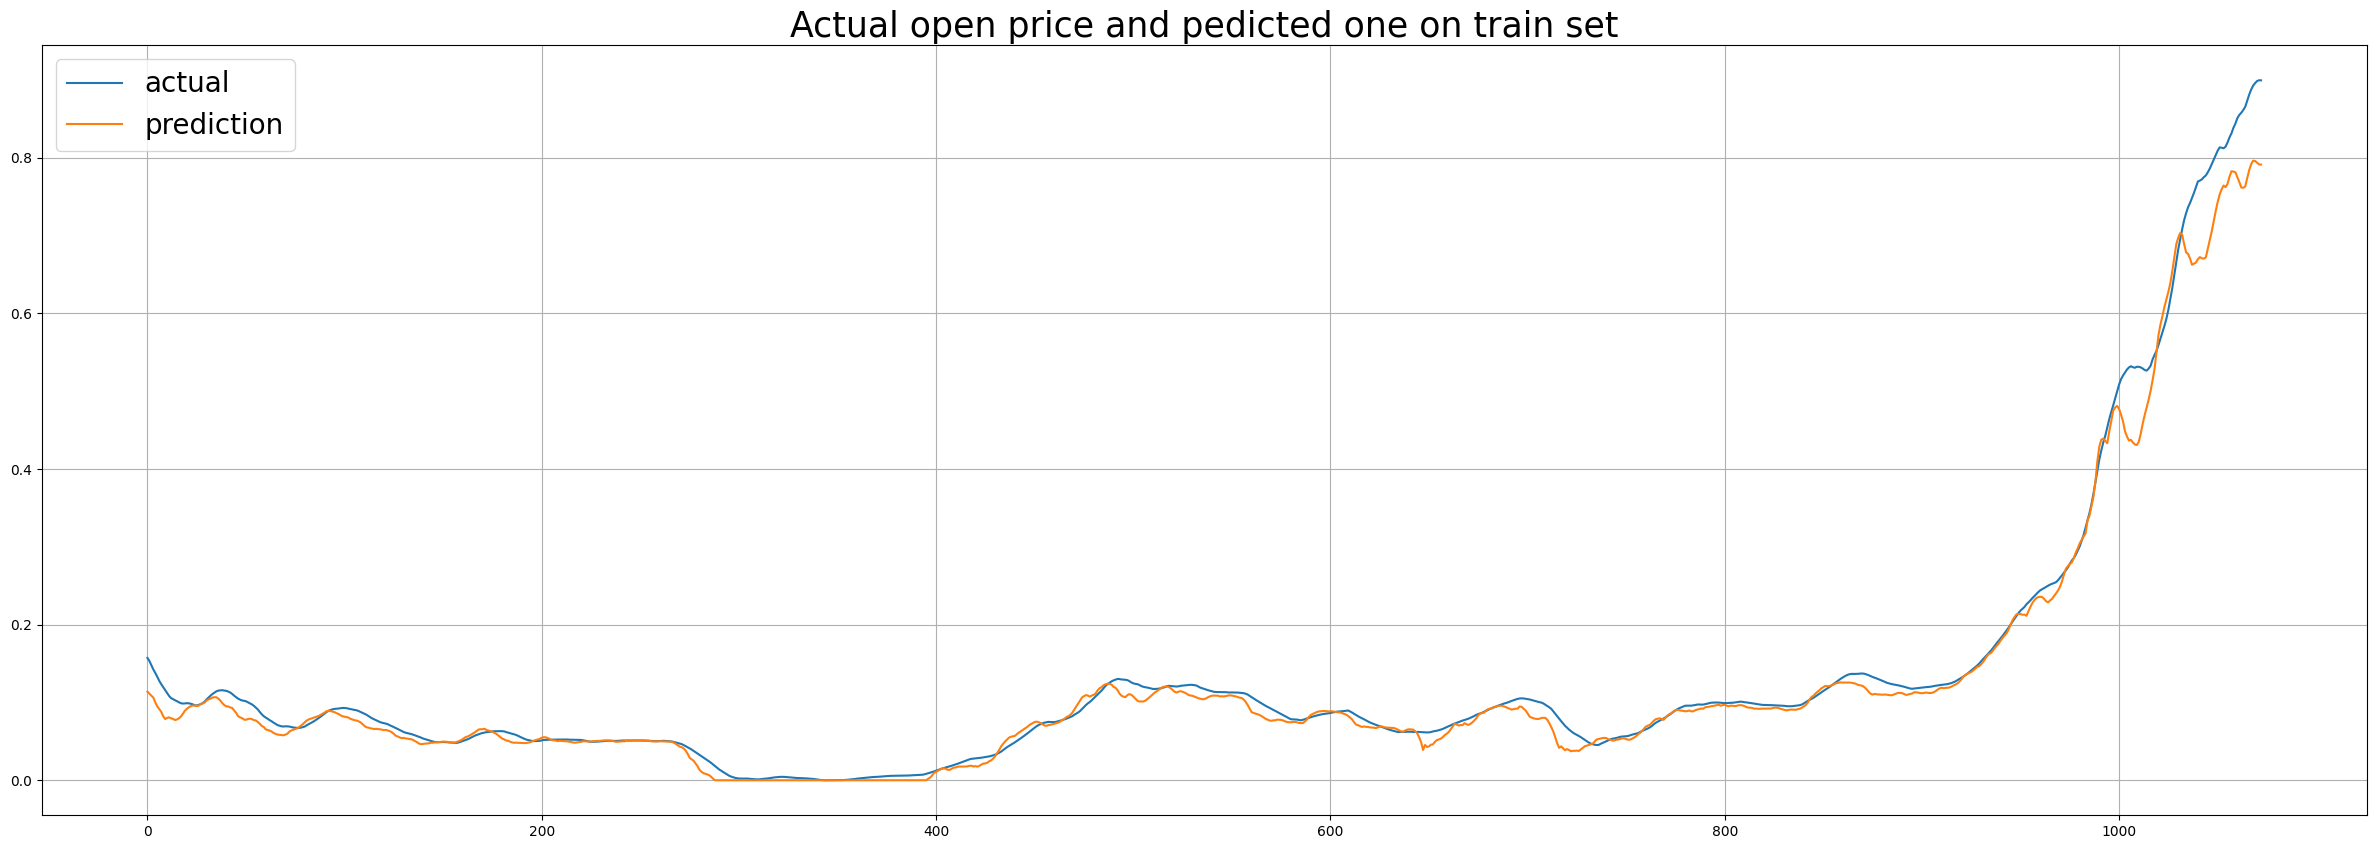

In [36]:
plt.figure(figsize=(30,10))
plt.plot(y_trainw, label="actual")
plt.plot(y_pr, label="prediction")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price and pedicted one on train set",fontsize=25)
plt.show()

In [37]:
y_pred=model.predict(X_testw)

9/9 [==============================] - 1s 61ms/step


In [38]:
model_loss = model.evaluate(X_testw, y_testw)

9/9 [==============================] - 1s 64ms/step - loss: 0.0109


In [39]:
def quantisation(v):
    v_lstm=np.zeros(len(v))
    tmp = (np.max(v)-np.min(v))/3
    for i in range(len(v)):
        if v[i] > np.max(v)-tmp:
            v_lstm[i] = 1
        elif v[i] < np.min(v)+tmp:
            v_lstm[i] = -1
        else:
            v_lstm[i] = 0
    return v_lstm

In [40]:
print(y_pred.shape)
v=np.diff(y_pred.reshape(y_pred.shape[0]),1)

v_lstm = quantisation(v)

(270, 1)


In [41]:
print(v)

[ 1.24472380e-03  5.57142496e-03  6.45953417e-03  5.67930937e-03
  4.89854813e-03  3.31503153e-03  4.14532423e-03 -5.17547131e-04
 -6.69741631e-03 -8.99720192e-03 -8.81236792e-03 -1.19345188e-02
 -6.93452358e-03 -9.69314575e-03 -1.04395151e-02 -1.27692819e-02
 -8.06206465e-03  3.77130508e-03  4.74447012e-03  5.84727526e-03
  6.60461187e-03  2.03841925e-03  2.45451927e-04 -4.25559282e-03
 -3.06451321e-03 -1.35147572e-03  4.54729795e-03  7.29608536e-03
  2.92754173e-03  5.04916906e-03 -3.75795364e-03 -7.72738457e-03
 -1.23078823e-02 -1.23000145e-02 -2.14001536e-02 -9.96178389e-03
 -2.02306509e-02 -2.52565742e-02 -2.70201564e-02 -1.97255015e-02
 -2.62456536e-02 -9.53894854e-03 -1.14563704e-02 -1.38626695e-02
 -5.71709871e-03 -1.11800432e-03 -1.51091814e-03 -6.83742762e-03
 -8.55404139e-03 -8.51994753e-03 -2.34204531e-03 -2.61455774e-03
 -2.92295218e-03 -8.33958387e-03 -7.98943639e-03 -6.39793277e-03
 -3.11091542e-03 -2.23881006e-03  8.28066468e-03  8.57561827e-03
  3.29321623e-03  4.23908

In [42]:
print(np.max(v))
print(np.min(v))

0.018334389
-0.027020156


In [43]:
print(v_lstm)

[ 0.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0. -1.  0.  0.  0. -1.  0.  1.
  1.  1.  1.  0.  0.  0.  0.  0.  1.  1.  0.  1.  0.  0. -1. -1. -1.  0.
 -1. -1. -1. -1. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  0.  0.  0. -1.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  1.  1.  1.
  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  1.  0.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  1.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. -1. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  1.  1.  0.  0. -1. -1. -1.  0

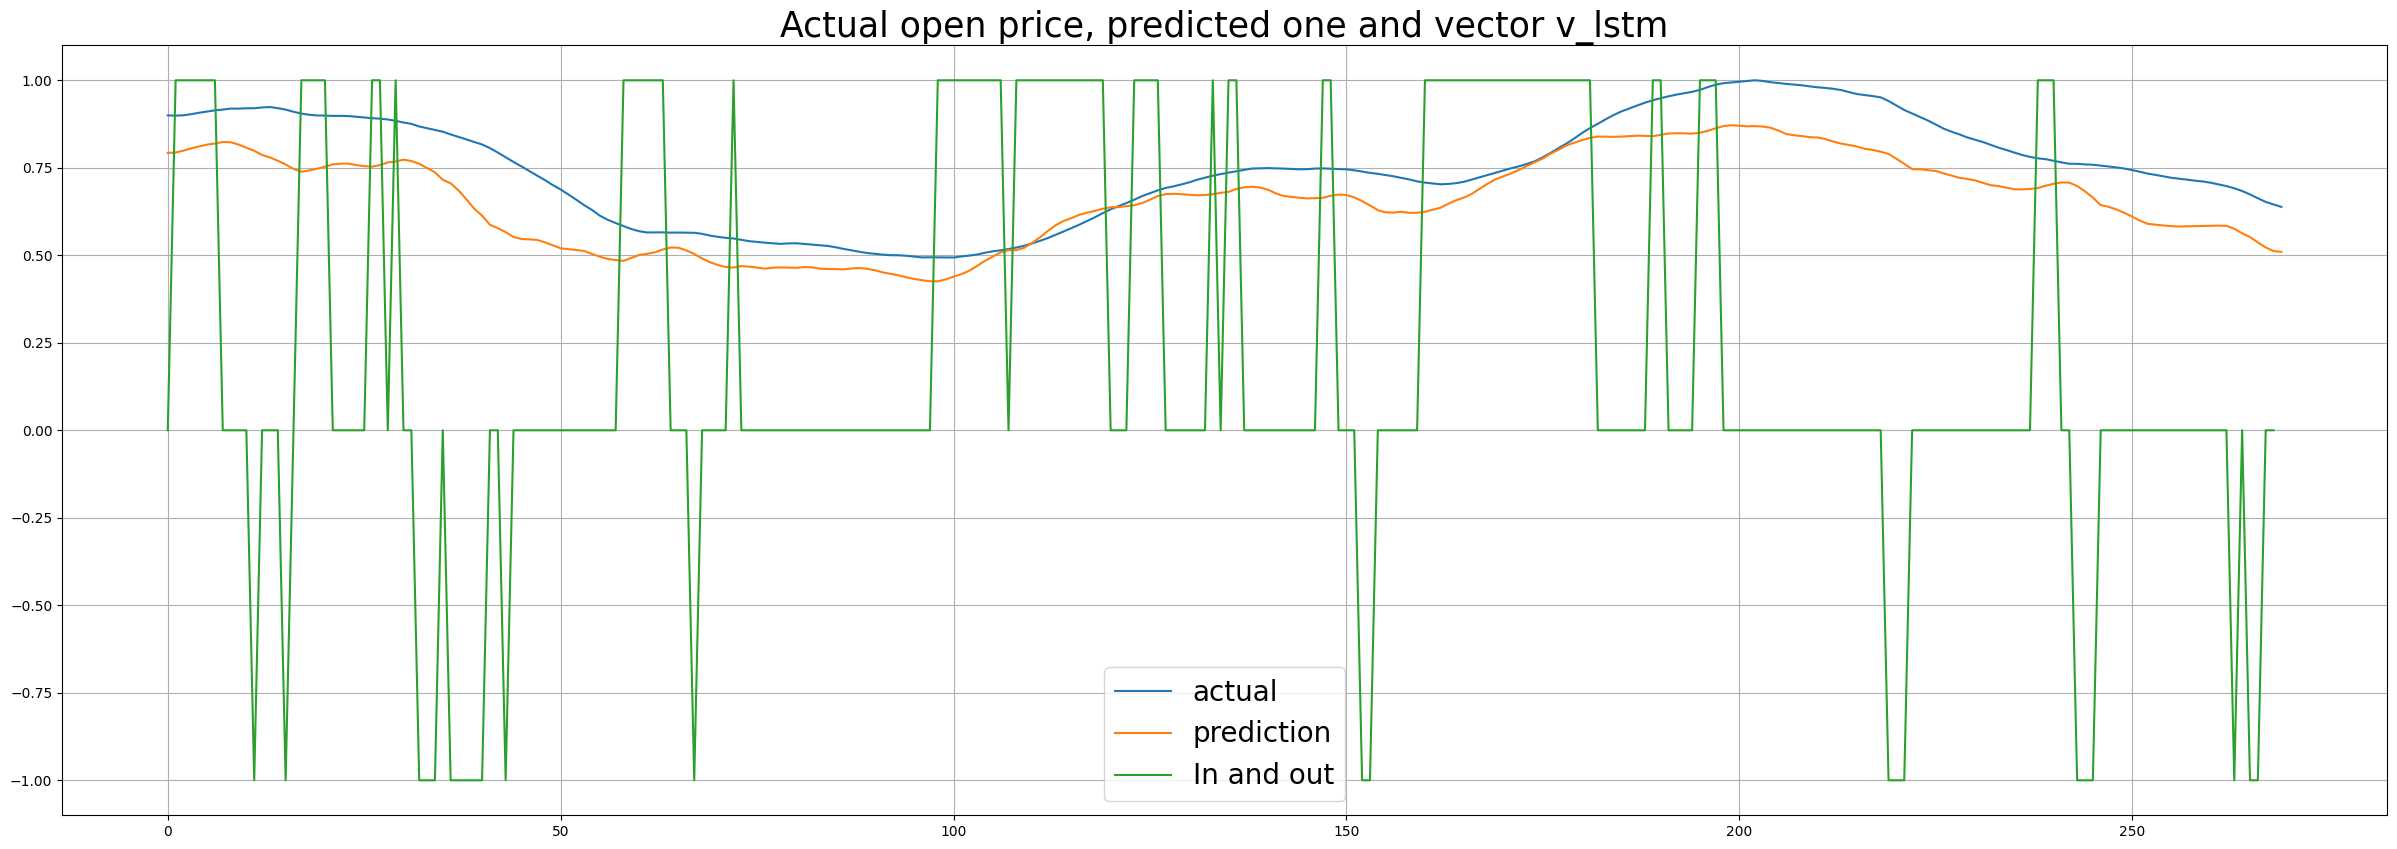

In [44]:
plt.figure(figsize=(30,10))
plt.plot(y_testw, label="actual")
plt.plot(y_pred, label="prediction")
plt.plot(v_lstm,label="In and out")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price, predicted one and vector v_lstm",fontsize=25)
plt.show()

In [45]:
print(test)

                    open          high           low         close  \
datetime                                                             
2021-04-11  59732.703229  59856.612708  59598.750625  59732.198750   
2021-04-12  60077.727187  60198.149062  59940.339688  60078.219271   
2021-04-13  61447.588229  61603.217812  61336.000104  61484.604687   
2021-04-14  63563.054063  63741.687917  63363.844375  63554.346562   
2021-04-15  62711.291042  62847.730417  62557.382917  62710.212188   
...                  ...           ...           ...           ...   
2022-01-23  35318.540104  35446.416354  35204.447500  35325.271354   
2022-01-24  34836.530104  35015.516250  34678.433750  34843.555208   
2022-01-25  36381.467292  36534.339271  36257.857500  36398.623333   
2022-01-26  37438.784688  37556.635625  37330.869583  37442.629375   
2022-01-27  36547.005000  36668.008854  36396.768021  36528.640625   

                volume      fd_cm      fd_nm  fd_cm_open  fd_nm_open  \
datetime         

In [46]:
test.shape

(269, 12)

In [47]:
v_bh=np.ones(test.shape[0])
v_ma=test["fd_cm_open"]>test["mv_avg_12"]

In [48]:
for i in v_ma:
    if i:
        print(i)

In [49]:
def gross_portfolio(df,w):
    portfolio=[ (w*df["rapp"]+(1-w))[:i].prod() for i in range(len(w))]
    return portfolio

In [50]:
trading_signal_week = pd.DataFrame(v_lstm,index=test.index,columns=["signal"])

In [51]:
y = test.close
y_short = y.ewm(span=2, adjust=True).mean()

print(y_short)

datetime
2021-04-11    59732.198750
2021-04-12    59991.714141
2021-04-13    61025.253750
2021-04-14    62732.391398
2021-04-15    62717.544158
                  ...     
2022-01-23    36063.320015
2022-01-24    35250.143477
2022-01-25    36015.796715
2022-01-26    36967.018488
2022-01-27    36674.766579
Name: close, Length: 269, dtype: float64


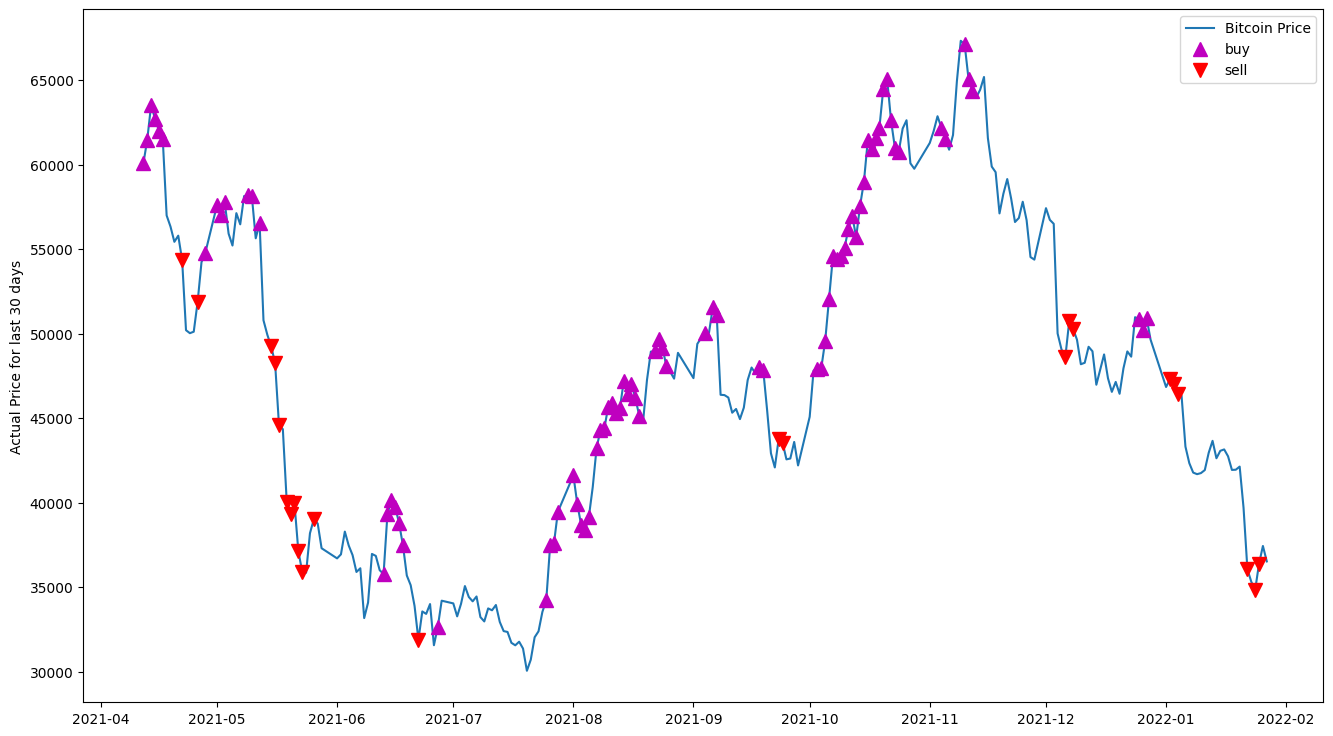

In [52]:
fig, (ax2) = plt.subplots(1, 1, figsize=(16,9))
duration = len(test)
y_temp = pd.DataFrame(y_short.tail(duration),index =test.tail(duration).index)
ax2.plot(test.tail(duration).index,y.tail(duration),label="Bitcoin Price")

ax2.set_ylabel("Actual Price for last 30 days")

# # Plot of the buy signals
ax2.plot(trading_signal_week.tail(duration).loc[trading_signal_week.signal == 1.0].index,
         y.tail(duration)[trading_signal_week.signal == 1.0],'^', markersize=10, color='m', label="buy")

# # Plot of the sell signals
ax2.plot(trading_signal_week.tail(duration).loc[trading_signal_week.signal == -1.0].tail(duration).index,
         y.tail(duration)[trading_signal_week.signal == -1.0],'v', markersize=10, color='r', label="sell")

ax2.legend(loc='best')

In [53]:
tax_cg=0.26
comm_bk=0.001

In [54]:
initial_capital = float(100000.0)

positions = pd.DataFrame(index=trading_signal_week.index).fillna(0.0)

positions['bitcoin_price'] = (initial_capital * (1 - tax_cg) * (1 - comm_bk)  / (model_loss * 0.4 * np.sum(y))) * trading_signal_week['signal']

portfolio = positions.multiply(y_short, axis=0)

pos_diff = positions.diff()

portfolio['holdings'] = (positions.multiply(y_short, axis=0)).sum(axis=1)

portfolio['cash'] = initial_capital - (pos_diff.multiply(y_short, axis=0)).sum(axis=1).cumsum()

portfolio['total'] = portfolio['cash'] + portfolio['holdings']

portfolio['returns'] = portfolio['total'].pct_change()

In [55]:
portfolio

bitcoin_price      holdings           cash          total  \
datetime                                                                
2021-04-11       0.000000      0.000000  100000.000000  100000.000000   
2021-04-12   79799.935296  79799.935296   20200.064704  100000.000000   
2021-04-13   81174.731718  81174.731718   20200.064704  101374.796422   
2021-04-14   83445.536542  83445.536542   20200.064704  103645.601246   
2021-04-15   83425.787001  83425.787001   20200.064704  103625.851705   
...                   ...           ...            ...            ...   
2022-01-23       0.000000      0.000000  132366.889666  132366.889666   
2022-01-24  -46889.128090 -46889.128090  179256.017755  132366.889666   
2022-01-25  -47907.586717 -47907.586717  179256.017755  131348.431039   
2022-01-26       0.000000      0.000000  130083.132371  130083.132371   
2022-01-27       0.000000      0.000000  130083.132371  130083.132371   

                 returns  
datetime                  
2021-04-11           NaN  
2021-04-12  0.000000e+00  
2021-04-13  1.374796e-02  
2021-04-14  2.240009e-02  
2021-04-15 -1.905488e-04  
...                  ...  
2022-01-23  1.505696e-02  
2022-01-24  2.220446e-16  
2022-01-25 -7.694210e-03  
2022-01-26 -9.633146e-03  
2022-01-27  0.000000e+00  

[269 rows x 5 columns]

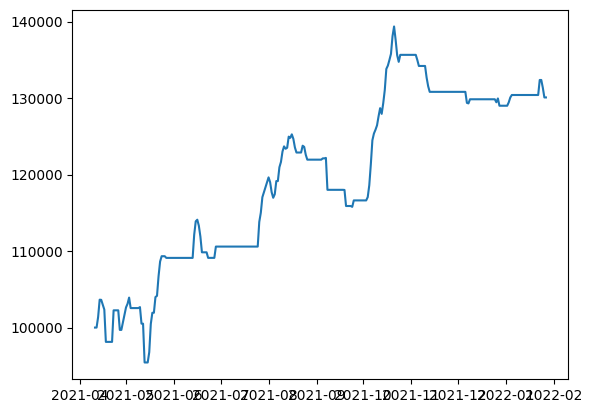

In [56]:
fig, ax1 = plt.subplots(1, 1)
ax1.plot(portfolio['total'])

In [58]:
window = len(y_short)

rolling_max = y_short.rolling(window, min_periods=1).max()
daily_drawdown =y_short/rolling_max - 1.0

max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

daily_drawdown.plot(label='daily_drawdown')
max_daily_drawdown.plot(label='max_daily_drawdown')

plt.legend(loc='best')
plt.show()

In [59]:
portfolio['trade signal'] = trading_signal_week
portfolio['trade_signal_change'] = portfolio['trade signal'].diff()
total_closed_trades = len(portfolio[portfolio['trade_signal_change'] != 0])

winning_trades = len(portfolio[(portfolio['trade signal'] == 1) & (portfolio['trade_signal_change'] == 1)])
losing_trades = len(portfolio[(portfolio['trade signal'] == -1) & (portfolio['trade_signal_change'] == -1)])

In [60]:
print(f'Total Closed Trades: {total_closed_trades}')
print(f'Winning Trades: {winning_trades}')
print(f'Losing Trades: {losing_trades}')

Total Closed Trades: 55
Winning Trades: 16
Losing Trades: 11


In [61]:
initial_portfolio_total = portfolio['cash'].iloc[0]
gross_profit = portfolio['cash'].iloc[-1] - initial_portfolio_total
transaction_costs = tax_cg* gross_profit + comm_bk * total_closed_trades
net_profit = gross_profit - transaction_costs

In [62]:
print(f'Initial Portfolio Total: {initial_portfolio_total}')
print(f'Gross Profit: {gross_profit}')
print(f'Net Profit: {net_profit}')

Initial Portfolio Total: 100000.0
Gross Profit: 30083.132370906576
Net Profit: 22261.462954470866


In [63]:
cumulative_returns = (1 + portfolio['total'].pct_change()).cumprod()
peak_value = cumulative_returns.cummax()
drawdown = (cumulative_returns - peak_value) / peak_value
max_drawdown = -drawdown.min()

print(f'Max Drawdown: {max_drawdown * 100:.2f}%')

Max Drawdown: 8.16%


In [64]:
portfolio['return_cash'] = portfolio['total'].diff();
losing_trades = portfolio.loc[(portfolio['trade signal'] == -1) & (portfolio['return_cash']< 0)]

gross_loss = -losing_trades['return_cash'].sum()

print(f'Gross Loss: {gross_loss:.2f}')

Gross Loss: 2641.96


In [65]:
average_winning_trade = portfolio.loc[portfolio['trade signal'] == 1  , 'return_cash'].mean()
average_losing_trade = -portfolio.loc[portfolio['trade signal'] == -1 , 'return_cash'].mean()

largest_winning_trade = portfolio['return_cash'].max()
largest_losing_trade = portfolio['return_cash'].min()

In [66]:
print(f'Average Winning Trade (in USDT): {average_winning_trade}')
print(f'Average Losing Trade (in USDT): {average_losing_trade}')
print(f'Largest Winning Trade (in USDT): {largest_winning_trade}')
print(f'Largest Losing Trade (in USDT): {largest_losing_trade}')

Average Winning Trade (in USDT): 442.4399173411424
Average Losing Trade (in USDT): -442.25020953770235
Largest Winning Trade (in USDT): 4124.417531193874
Largest Losing Trade (in USDT): -5074.921828632985


In [57]:
returns = portfolio['returns']
sharpe_ratio = np.sqrt(len(y_short)) * (returns.mean() / returns.std())

print(f'Sharpe Ratio: {sharpe_ratio}')

1.8271358807513476


In [67]:
risk_free_rate = 0.02

returns = portfolio['total'].pct_change().dropna()
sortino_ratio = np.sqrt(len(returns[returns < 0])) * (returns.mean() / returns[returns < 0].std())

In [68]:
print(f'Sortino Ratio: {sortino_ratio}')

Sortino Ratio: 0.6690137980383826


In [69]:
max_drawdown = portfolio['total'].min() - initial_portfolio_total

average_holding_duration = (portfolio['trade signal'].diff().abs() > 0).mean()

max_dip = daily_drawdown.min()
average_dip = daily_drawdown.mean()

In [70]:
print(f'14. Average Holding Duration per Trade: {average_holding_duration}')
print(f'15. Max Dip: {max_dip}, Average Dip: {average_dip}')

14. Average Holding Duration per Trade: 0.20074349442379183
15. Max Dip: -0.5131927210552611, Average Dip: -0.26125237137699797
